<a href="https://colab.research.google.com/github/JRasmusBm/chatbot-
epsilon/blob/master/Trainer.ipynb" target="_parent"><img
src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In
Colab"/></a>

# This is the file in which we perform training of the NN

# Load
Data

## In Colab

In [1]:
#from google.colab import files
#uploaded = files.upload()
#file_name = "amazon_cells_labelled.txt"
#uploaded[file_name].decode("utf-8")

## Locally

In [2]:
data_folder = "../../data"
training_models_folder = "../../trained_models"
file_name = f"{data_folder}/amazon_cells_labelled.txt"
json_file = f"{data_folder}/amazon_cells_labelled.json"

# Import code (from TA)

# Imports

In [3]:
from torchtext import data
from torchtext import datasets
import torch
import torch.nn as nn
import json
import time
import numpy as np

# Extract Data

First, we create lists of labels and sentences. The indices in
the one
correspond to those in the other. Due to restrictions in torchtext,
write it as
json to disk.

In [4]:
# with open(file_name) as f:
#     contents = f.read()
# labels = []
# sentences = []
# for line in (l for l in contents.split("\n") if l):
#     labels.append(int(line[-1]))
#     sentence = str.strip(line[:-1])
#     while len(sentence.split(" ")) < 5:
#         sentence += " a"
#     sentences.append(sentence)
# data_json = [
#     dict(label=label, text=text) for label, text in zip(labels, sentences)
# ]
# with open(json_file, "w") as f:
    #text = "\n".join(json.dumps(line) for line in data_json)
    #f.write(text)

## Validate

In [5]:
# with open(json_file) as f:
#     json_written = [json.loads(line) for line in f.read().split("\n")]
#     for line in json_written:
#         if line["label"] not in [0, 1]:
#             print(line)
#         if len(line["text"].split(" ")) < 5:
#             print(line)

# Generate Torchtext Dataset

In [6]:
def generate_bigrams(x):
    n_grams = set(zip(*[x[i:] for i in range(2)]))
    for n_gram in n_grams:
        x.append(" ".join(n_gram))
    return x

In [7]:
import random

from IPython.core.debugger import set_trace
from torch.utils.data.dataset import random_split

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize="spacy", batch_first=True,)
LABEL = data.LabelField(dtype=torch.float)
# fields = dict(text=("text", TEXT), label=("label", LABEL),)

# dataset = data.TabularDataset(path=json_file, format="json", fields=fields,)
# help(dataset)
# training_data, test_data, validation_data = dataset.split(
#    split_ratio=[0.7, 0.2, 0.1], random_state=random.seed(SEED)
# )
training_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
training_data, validation_data = training_data.split(
    random_state=random.seed(SEED)
)

## Validate

In [8]:
print(f"Length (Training Data): {len(training_data)}")
print(f"Length (Test Data): {len(test_data)}")
print(f"Length (Validation Data): {len(validation_data)}")

Length (Training Data): 17500
Length (Test Data): 25000
Length (Validation Data): 7500


# Build Vocab

In [9]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(
  training_data,
  vectors="glove.6B.100d",
  unk_init=torch.Tensor.normal_,
  max_size = MAX_VOCAB_SIZE
)
LABEL.build_vocab(training_data)

.vector_cache/glove.6B.zip: 862MB [19:30, 737kB/s]                                
100%|█████████▉| 398913/400000 [00:20<00:00, 19535.56it/s]

## Validate

In [10]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")
print(TEXT.vocab.freqs.most_common(10))

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2
[('the', 202487), (',', 191683), ('.', 165574), ('a', 109268), ('and', 109089), ('of', 100651), ('to', 93681), ('is', 75914), ('in', 61378), ('I', 54276)]


# Create Iterators

In [11]:
BATCH_SIZE = 64

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

training_iterator, validation_iterator, test_iterator = data.BucketIterator.splits(
    (training_data, validation_data, test_data),
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch = True,
    device = device)

# Build Model

In [12]:
class CNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        n_filters,
        filter_sizes,
        output_dim,
        dropout,
        pad_idx,
    ):
        super().__init__()
        self.embedding = nn.Embedding(
            vocab_size, embedding_dim, padding_idx=pad_idx
        )
        self.conv_0 = nn.Conv2d(
            in_channels=1,
            out_channels=n_filters,
            kernel_size=(filter_sizes[0], embedding_dim),
        )
        self.conv_1 = nn.Conv2d(
            in_channels=1,
            out_channels=n_filters,
            kernel_size=(filter_sizes[1], embedding_dim),
        )
        self.conv_2 = nn.Conv2d(
            in_channels=1,
            out_channels=n_filters,
            kernel_size=(filter_sizes[2], embedding_dim),
        )
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.embedding(text)
        embedded = embedded.unsqueeze(1)
        conved_0 = nn.functional.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = nn.functional.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = nn.functional.relu(self.conv_2(embedded).squeeze(3))
        pooled_0 = nn.functional.max_pool1d(
            conved_0, conved_0.shape[2]
        ).squeeze(2)
        pooled_1 = nn.functional.max_pool1d(
            conved_1, conved_1.shape[2]
        ).squeeze(2)
        pooled_2 = nn.functional.max_pool1d(
            conved_2, conved_2.shape[2]
        ).squeeze(2)
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim=1))
        return self.fc(cat)

# Instantiate Model

In [13]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [3, 4, 5]
OUTPUT_DIM = 1
DROPOUT = 0.5
PADDING_INDEX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(
    INPUT_DIM,
    EMBEDDING_DIM,
    N_FILTERS,
    FILTER_SIZES,
    OUTPUT_DIM,
    DROPOUT,
    PADDING_INDEX,
)

## Validate

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,620,801 trainable parameters


# Train Model

In [15]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([25002, 100])


In [16]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.1263,  0.1299,  0.7107,  ...,  0.2647, -0.7851,  0.2955],
        [-0.1709,  0.3923, -0.1879,  ...,  0.9795,  0.5425,  1.5589],
        [ 0.2429, -0.0744,  0.1650,  ...,  0.6570,  0.1391, -0.2840]])

In [17]:
UNKNOWN_INDEX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNKNOWN_INDEX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PADDING_INDEX] = torch.zeros(EMBEDDING_DIM)

In [18]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [19]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)


def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        predictions = model(batch.text).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [20]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            predictions = model(batch.text).squeeze(1)
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [21]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Run Training

In [23]:
N_EPOCHS = 20

best_validation_loss = float('inf')

training_losses = []
validation_losses = []
times_best_found = 0
limit = 5

for epoch in range(N_EPOCHS):
    start_time = time.time()
    training_loss, training_acc = train(model, training_iterator, optimizer, criterion)
    validation_loss, validation_acc = evaluate(model, validation_iterator, criterion)
    end_time = time.time()
    training_losses.append(training_loss)
    validation_losses.append(validation_loss)
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if validation_loss < best_validation_loss:
        times_best_found = 0
        best_validation_loss = validation_loss
        torch.save(model.state_dict(), f'{training_models_folder}/cnn_20_epochs_imdb.pt')
    else:
        print("NOT THE BEST")
        times_best_found += 1
    if limit <= times_best_found:
        break
    print(f"Stopping in {limit - times_best_found}")
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\ttraining Loss: {training_loss:.3f} | training Acc: {training_acc*100:.2f}%')
    print(f'\t Val. Loss: {validation_loss:.3f} |  Val. Acc: {validation_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 3m 7s
	training Loss: 0.315 | training Acc: 86.68%
	 Val. Loss: 0.341 |  Val. Acc: 85.28%
Epoch: 02 | Epoch Time: 3m 9s
	training Loss: 0.232 | training Acc: 90.78%
	 Val. Loss: 0.339 |  Val. Acc: 85.99%
Epoch: 03 | Epoch Time: 3m 10s
	training Loss: 0.164 | training Acc: 93.89%
	 Val. Loss: 0.314 |  Val. Acc: 87.52%
Epoch: 04 | Epoch Time: 3m 9s
	training Loss: 0.112 | training Acc: 96.08%
	 Val. Loss: 0.346 |  Val. Acc: 87.23%
Epoch: 05 | Epoch Time: 3m 7s
	training Loss: 0.076 | training Acc: 97.49%
	 Val. Loss: 0.378 |  Val. Acc: 86.67%
Epoch: 06 | Epoch Time: 3m 8s
	training Loss: 0.055 | training Acc: 98.24%
	 Val. Loss: 0.415 |  Val. Acc: 86.82%
Epoch: 07 | Epoch Time: 3m 13s
	training Loss: 0.038 | training Acc: 98.97%
	 Val. Loss: 0.445 |  Val. Acc: 86.92%
Epoch: 08 | Epoch Time: 2m 39s
	training Loss: 0.029 | training Acc: 99.13%
	 Val. Loss: 0.476 |  Val. Acc: 86.94%


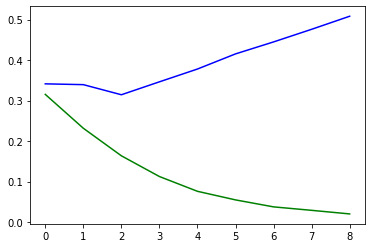

In [27]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(validation_losses, color="blue")
plt.plot(training_losses, color="green")